In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
# from joblib import Parallel, delayed

import pandas as pd

In [2]:
stations = pd.read_csv("/users/rpayne/data/unproc/STN_ECCC/climate_station_list.csv")

In [3]:
relevant_stations = stations[~np.isnan(stations["HLY First Year"])][stations["Province"] == "BRITISH COLUMBIA"][stations["HLY Last Year"] > 1990].sort_values("HLY First Year")
# relevant_stations = relevant_stations[relevant_stations["Station Name"].isin(stns)]
stn_coords = np.dstack((relevant_stations['Longitude'].values,relevant_stations['Latitude'].values))[0]
stns_fromlist = relevant_stations['Station Name'].values
ids_fromlist = relevant_stations['Climate ID'].values
print(len(stns_fromlist), "stations found in the list")
relevant_stations

# Write Climate IDs to a text file, one per line
# np.savetxt('/users/rpayne/stn_climate_ids.txt', relevant_stations['Climate ID'].values, fmt='%s')

274 stations found in the list


/tmp/ipykernel_2089988/2351222015.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_stations = stations[~np.isnan(stations["HLY First Year"])][stations["Province"] == "BRITISH COLUMBIA"][stations["HLY Last Year"] > 1990].sort_values("HLY First Year")
/tmp/ipykernel_2089988/2351222015.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_stations = stations[~np.isnan(stations["HLY First Year"])][stations["Province"] == "BRITISH COLUMBIA"][stations["HLY Last Year"] > 1990].sort_values("HLY First Year")


,Station Name,Province,Latitude,Longitude,Elevation,Climate ID,WMO Identifier,TC Identifier,First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year
8059,VICTORIA INT'L A,BRITISH COLUMBIA,48.65,-123.43,19.5,1018620,71799.0,YYJ,1940,2013,1953.0,2013.0,1940.0,2013.0,1940.0,2013.0
1190,CAPE ST JAMES,BRITISH COLUMBIA,51.93,-131.02,92.0,1051350,NaN,NaN,1925,1998,1953.0,1992.0,1925.0,1998.0,1925.0,1998.0
8050,VICTORIA GONZALES HTS,BRITISH COLUMBIA,48.41,-123.33,69.5,1018610,NaN,WLM,1898,2004,1953.0,2000.0,1898.0,2004.0,1898.0,2004.0
7961,VANCOUVER INT'L A,BRITISH COLUMBIA,49.20,-123.18,4.3,1108447,NaN,YVR,1937,2013,1953.0,2013.0,1937.0,2013.0,1937.0,2013.0
7765,TRIPLE ISLAND,BRITISH COLUMBIA,54.29,-130.88,20.7,1068250,NaN,WTI,1953,2025,1953.0,2001.0,1989.0,2025.0,1989.0,2007.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5855,PORT HARDY AIRPORT,BRITISH COLUMBIA,50.68,-127.38,21.6,1026273,73014.0,VHD,2023,2025,2023.0,2025.0,2023.0,2025.0,NaN,NaN
7958,VANCOUVER HARBOUR,BRITISH COLUMBIA,49.29,-123.11,0.0,110Q44V,NaN,YHC,2023,2025,2023.0,2025.0,2023.0,2025.0,NaN,NaN
7947,VANCOUVER BOUNDARY BAY,BRITISH COLUMBIA,49.07,-123.01,1.8,1100909,NaN,ZBB,2023,2025,2023.0,2025.0,2023.0,2025.0,NaN,NaN
5724,PITT MEADOWS,BRITISH COLUMBIA,49.22,-122.71,3.7,110617P,NaN,YPK,2023,2025,2023.0,2025.0,2023.0,2025.0,NaN,NaN


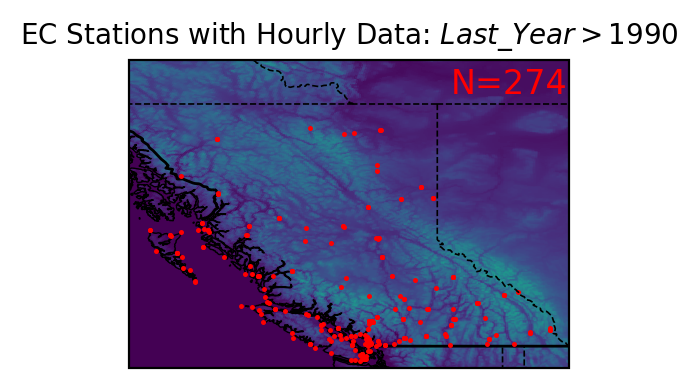

In [5]:
topography_hr = xr.open_dataset("/users/rpayne/data/topography/hr/HGT_orig.nc")
lon = topography_hr['XLONG'].squeeze()
lat = topography_hr['XLAT'].squeeze()
hgt = topography_hr['HGT'].squeeze()

# Create a figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()},figsize=(4,2),dpi=200)

# Plot using pcolormesh
mesh = ax.pcolormesh(lon, lat, hgt, transform=ccrs.PlateCarree(), shading='auto')
ax.add_feature(cfeature.BORDERS, linewidth=1)   # Country borders
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)
for coords in stn_coords:
    lon, lat = coords
    ax.plot(lon, lat, marker='o', color='red', markersize=.8, transform=ccrs.PlateCarree())
ax.set_xlim(-134, -114)
ax.set_ylim(48, 62)
ax.text(-119.4, 60.5, "N=274", fontsize=12, transform=ccrs.PlateCarree(), color='red')

# Add coastlines and colorbar
ax.coastlines(linewidth=0.5)

ax.set_title("EC Stations with Hourly Data: $Last\_Year > 1990$", fontsize=10)
plt.show()

In [6]:
# Takes ~5 minutes to run

wx_data_fnames = sorted(glob("/users/rpayne/data/unproc/STN_ECCC/hourly/climate_hourly_BC_*.csv"))
df = pd.concat(
    (pd.read_csv(f, encoding='latin1') for f in wx_data_fnames),
    ignore_index=True
)
df['Date/Time (LST)'] = pd.to_datetime(df['Date/Time (LST)'], format='%Y-%m-%d %H:%M')
FIRST_YEAR = 1999
LAST_YEAR = 2023
df = df[df['Date/Time (LST)'].dt.year >= FIRST_YEAR]  # Filter for data after FIRST_YEAR
df = df[df['Date/Time (LST)'].dt.year <= LAST_YEAR]  # Filter for data before LAST_YEAR
df.set_index('Date/Time (LST)', inplace=True)
df

/tmp/ipykernel_2061512/1808808491.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Time (LST),Flag,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
Date/Time (LST),,,,,,,,,,,,,,,,,,,,,
2007-11-27 08:00:00,-123.72,48.82,NORTH COWICHAN,1015630,2007,11,27,08:00,NaN,-2.4,...,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN
2007-11-27 09:00:00,-123.72,48.82,NORTH COWICHAN,1015630,2007,11,27,09:00,NaN,-1.1,...,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN
2007-11-27 10:00:00,-123.72,48.82,NORTH COWICHAN,1015630,2007,11,27,10:00,NaN,1.4,...,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN
2007-11-27 11:00:00,-123.72,48.82,NORTH COWICHAN,1015630,2007,11,27,11:00,NaN,4.5,...,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN
2007-11-27 12:00:00,-123.72,48.82,NORTH COWICHAN,1015630,2007,11,27,12:00,NaN,4.5,...,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-130.03,58.43,DEASE LAKE (AUT),119BLM0,2023,12,31,19:00,NaN,-11.1,...,NaN,NaN,NaN,92.30,NaN,NaN,NaN,-17.0,NaN,NaN
2023-12-31 20:00:00,-130.03,58.43,DEASE LAKE (AUT),119BLM0,2023,12,31,20:00,NaN,-11.5,...,NaN,NaN,NaN,92.32,NaN,NaN,NaN,-15.0,NaN,NaN
2023-12-31 21:00:00,-130.03,58.43,DEASE LAKE (AUT),119BLM0,2023,12,31,21:00,NaN,-11.7,...,NaN,NaN,NaN,92.32,NaN,NaN,NaN,-14.0,NaN,NaN


In [7]:
print(df.columns)

def get_stn(stn_name, data=df):
    stn = data[data["Station Name"] == stn_name]
    return stn

stns = df["Station Name"].unique()

temp = df["Temp (°C)"]
ws = df["Wind Spd (km/h)"]
rh = df["Rel Hum (%)"]
ps = df["Stn Press (kPa)"]

print(len(stns), "stations")

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
       'Month', 'Day', 'Time (LST)', 'Flag', 'Temp (°C)', 'Temp Flag',
       'Dew Point Temp (°C)', 'Dew Point Temp Flag', 'Rel Hum (%)',
       'Rel Hum Flag', 'Precip. Amount (mm)', 'Precip. Amount Flag',
       'Wind Dir (10s deg)', 'Wind Dir Flag', 'Wind Spd (km/h)',
       'Wind Spd Flag', 'Visibility (km)', 'Visibility Flag',
       'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx', 'Hmdx Flag', 'Wind Chill',
       'Wind Chill Flag', 'Weather'],
      dtype='object')
126 stations


In [8]:
# Create a dictionary mapping station name to (lat, lon) from df
stn_latlon = {}
for stn in stns:
    stn_rows = df[df["Station Name"] == stn]
    if not stn_rows.empty:
        lat = stn_rows["Latitude (y)"].iloc[0]
        lon = stn_rows["Longitude (x)"].iloc[0]
        stn_latlon[stn] = (lat, lon)
    else:
        stn_latlon[stn] = (None, None)

In [9]:
for x in stn_latlon.items():
    print(x)

('NORTH COWICHAN', (np.float64(48.82), np.float64(-123.72)))
('VICTORIA UNIVERSITY CS', (np.float64(48.46), np.float64(-123.3)))
('VICTORIA GONZALES HTS', (np.float64(48.41), np.float64(-123.33)))
('VICTORIA GONZALES CS', (np.float64(48.41), np.float64(-123.32)))
('VICTORIA HARBOUR A', (np.float64(48.42), np.float64(-123.39)))
("VICTORIA INT'L A", (np.float64(48.65), np.float64(-123.43)))
('VICTORIA INTL A', (np.float64(48.65), np.float64(-123.43)))
('CAMPBELL RIVER A', (np.float64(49.95), np.float64(-125.27)))
('COMOX A', (np.float64(49.72), np.float64(-124.9)))
('NANAIMO A', (np.float64(49.05), np.float64(-123.87)))
('PORT HARDY A', (np.float64(50.68), np.float64(-127.37)))
('CAPE SCOTT', (np.float64(50.78), np.float64(-128.43)))
('ESTEVAN POINT CS', (np.float64(49.38), np.float64(-126.54)))
('PORT ALBERNI (AUT)', (np.float64(49.32), np.float64(-124.93)))
('SARTINE ISLAND (AUT)', (np.float64(50.82), np.float64(-128.91)))
('SOLANDER ISLAND (AUT)', (np.float64(50.11), np.float64(-127.9

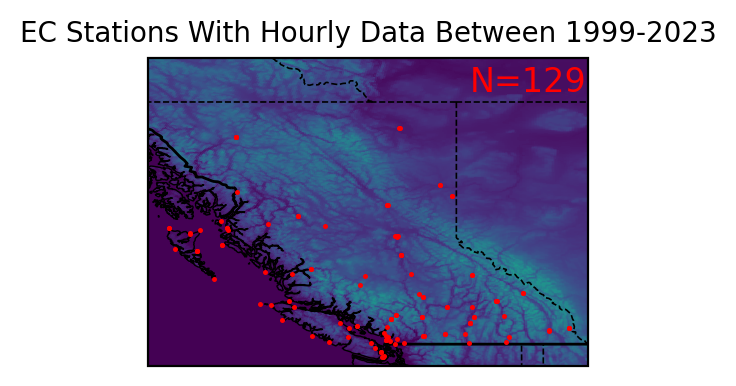

In [10]:
topography_hr = xr.open_dataset("/users/rpayne/data/topography/hr/HGT_orig.nc")
lon = topography_hr['XLONG'].squeeze()
lat = topography_hr['XLAT'].squeeze()
hgt = topography_hr['HGT'].squeeze()

# Create a figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()},figsize=(4,2),dpi=200)

# Plot using pcolormesh
mesh = ax.pcolormesh(lon, lat, hgt, transform=ccrs.PlateCarree(), shading='auto')
ax.add_feature(cfeature.BORDERS, linewidth=1)   # Country borders
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)
for stn in stns:
    lat, lon = stn_latlon[stn]
    ax.plot(lon, lat, marker='o', color='red', markersize=.8, transform=ccrs.PlateCarree())
ax.set_xlim(-134, -114)
ax.set_ylim(48, 62)
ax.text(-119.4, 60.5, "N=129", fontsize=12, transform=ccrs.PlateCarree(), color='red')

# Add coastlines and colorbar
ax.coastlines(linewidth=0.5)

ax.set_title(f"EC Stations With Hourly Data Between {FIRST_YEAR}-{LAST_YEAR}", fontsize=10)
plt.show()

In [10]:
vars = [
    "Temp (°C)",
    "Wind Spd (km/h)",
    "Precip. Amount (mm)",
    "Stn Press (kPa)",
]
mins = {stn: {} for stn in stns}
maxs = {stn: {} for stn in stns}

for i,stn in enumerate(stns):
    print(f"Station {i+1}/{len(stns)}: {stn}")
    stn_data = get_stn(stn)
    for var in vars:
        stn_data_var = stn_data[var]
        try:
            data_max = stn_data_var.max()
            data_min = stn_data_var.min()
            mins[stn][var] = data_min
            maxs[stn][var] = data_max
        except:
            print(f"ERROR processing {var} for {stn}: trying to convert to numeric")
            stn_data_var = pd.to_numeric(stn_data_var, errors='coerce')
            data_max = stn_data_var.max()
            data_min = stn_data_var.min()
            mins[stn][var] = data_min
            maxs[stn][var] = data_max

Station 1/126: NORTH COWICHAN
Station 2/126: VICTORIA UNIVERSITY CS


Station 3/126: VICTORIA GONZALES HTS
Station 4/126: VICTORIA GONZALES CS
Station 5/126: VICTORIA HARBOUR A
Station 6/126: VICTORIA INT'L A
Station 7/126: VICTORIA INTL A
Station 8/126: CAMPBELL RIVER A
Station 9/126: COMOX A
Station 10/126: NANAIMO A
Station 11/126: PORT HARDY A
Station 12/126: CAPE SCOTT
Station 13/126: ESTEVAN POINT CS
Station 14/126: PORT ALBERNI (AUT)
Station 15/126: SARTINE ISLAND (AUT)
Station 16/126: SOLANDER ISLAND (AUT)
Station 17/126: TOFINO A
Station 18/126: HOWE SOUND - PAM ROCKS
Station 19/126: POWELL RIVER A
Station 20/126: POWELL RIVER
Station 21/126: SQUAMISH AIRPORT
Station 22/126: WHISTLER
Station 23/126: WHISTLER A
Station 24/126: CAPE ST JAMES
Station 25/126: KINDAKUN ROCKS (AUT)
Station 26/126: LANGARA
Station 27/126: LANGARA ISLAND RCS
Station 28/126: MASSET AIRPORT
Station 29/126: MASSET A
Station 30/126: ROSE SPIT (AUT)
Station 31/126: SANDSPIT A
Station 32/126: SANDSPIT AIRPORT AUTO
Station 33/126: SANDSPIT
Station 34/126: SANDSPIT AWOS
Station

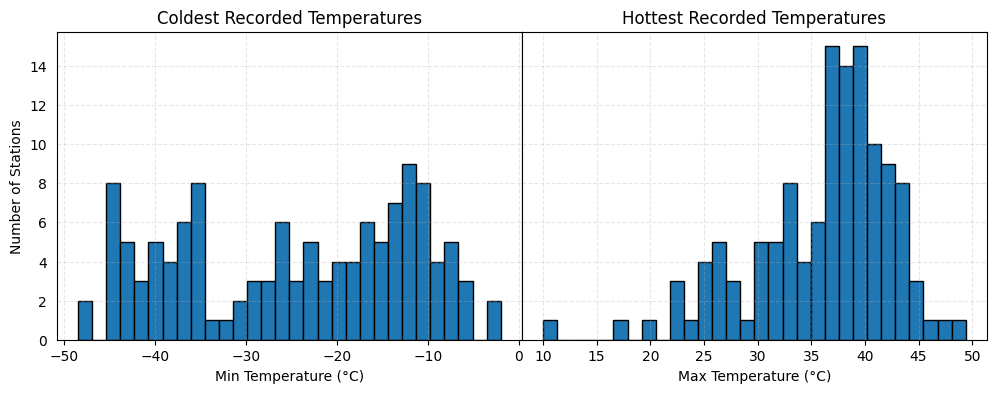

In [38]:
# Extract all max and min temperatures from the maxs and mins dictionaries
max_temps = [maxs[stn]["Temp (°C)"] for stn in maxs if "Temp (°C)" in maxs[stn]]
min_temps = [mins[stn]["Temp (°C)"] for stn in mins if "Temp (°C)" in mins[stn]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(min_temps, bins=30, edgecolor='black')
axes[0].set_xlabel("Min Temperature (°C)")
axes[0].set_ylabel("Number of Stations")
axes[0].set_title("Coldest Recorded Temperatures")

axes[1].hist(max_temps, bins=30, edgecolor='black')
axes[1].set_xlabel("Max Temperature (°C)")
axes[1].set_title("Hottest Recorded Temperatures")

for ax in axes:
    ax.tick_params(axis='y', left=False)
    ax.grid(alpha=.3, ls='--')
plt.subplots_adjust(wspace=0.)
plt.show()

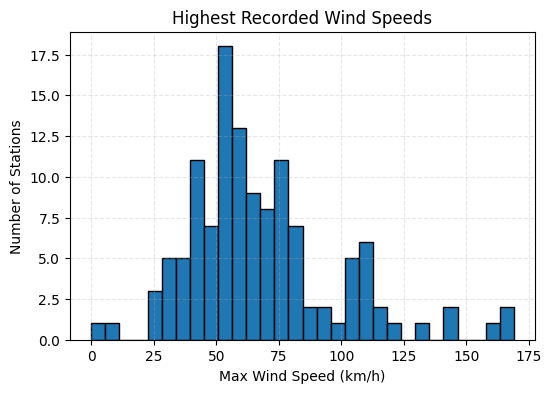

In [39]:
# Extract all max wind speeds from the maxs dictionary
max_ws = [maxs[stn]["Wind Spd (km/h)"] for stn in maxs if "Wind Spd (km/h)" in maxs[stn]]

plt.figure(figsize=(6, 4))
plt.hist(max_ws, bins=30, edgecolor='black')
plt.xlabel("Max Wind Speed (km/h)")
plt.ylabel("Number of Stations")
plt.title("Highest Recorded Wind Speeds")
plt.grid(alpha=.3, ls='--')
plt.show()

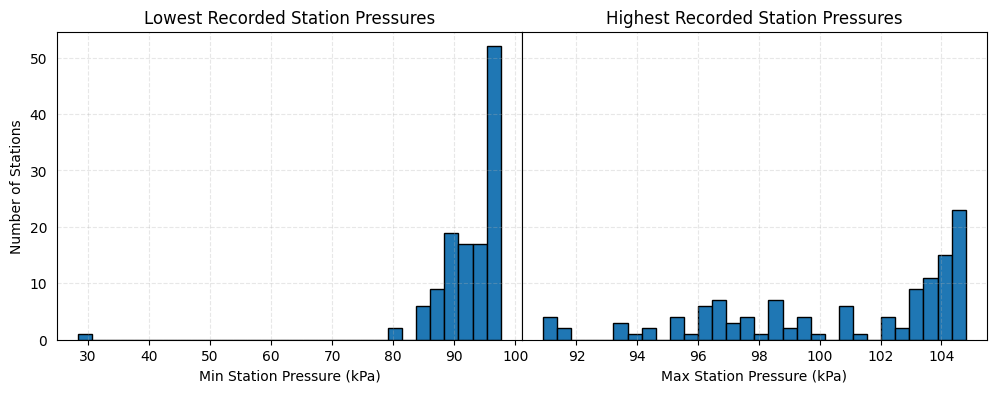

In [40]:
# Extract all max and min station pressures from the maxs and mins dictionaries
max_pressures = [maxs[stn]["Stn Press (kPa)"] for stn in maxs if "Stn Press (kPa)" in maxs[stn]]
min_pressures = [mins[stn]["Stn Press (kPa)"] for stn in mins if "Stn Press (kPa)" in mins[stn]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(min_pressures, bins=30, edgecolor='black')
axes[0].set_xlabel("Min Station Pressure (kPa)")
axes[0].set_ylabel("Number of Stations")
axes[0].set_title("Lowest Recorded Station Pressures")

axes[1].hist(max_pressures, bins=30, edgecolor='black')
axes[1].set_xlabel("Max Station Pressure (kPa)")
axes[1].set_title("Highest Recorded Station Pressures")

for ax in axes:
    ax.tick_params(axis='y', left=False)
    ax.grid(alpha=.3, ls='--')
plt.subplots_adjust(wspace=0.)
plt.show()

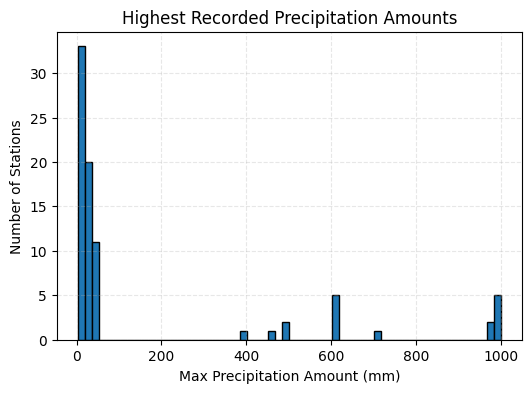

In [41]:
# Extract all max precipitation amounts from the maxs dictionary
max_precip = [maxs[stn]["Precip. Amount (mm)"] for stn in maxs if "Precip. Amount (mm)" in maxs[stn]]

plt.figure(figsize=(6, 4))
plt.hist(max_precip, bins=60, edgecolor='black')
plt.xlabel("Max Precipitation Amount (mm)")
plt.ylabel("Number of Stations")
plt.title("Highest Recorded Precipitation Amounts")
plt.grid(alpha=.3, ls='--')
plt.show()

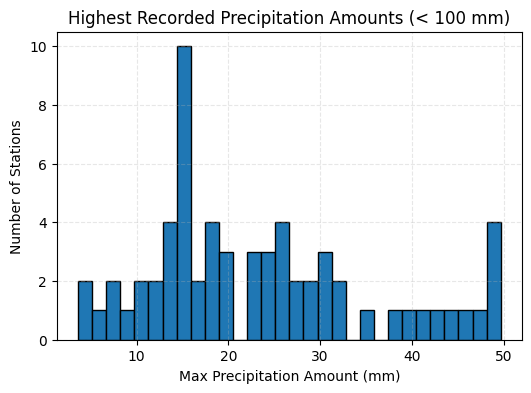

In [42]:
# Extract all max precipitation amounts from the maxs dictionary
max_precip = np.array([maxs[stn]["Precip. Amount (mm)"] for stn in maxs if "Precip. Amount (mm)" in maxs[stn]])
max_precip = max_precip[max_precip < 100]  # Remove NaN values

plt.figure(figsize=(6, 4))
plt.hist(max_precip, bins=30, edgecolor='black')
plt.xlabel("Max Precipitation Amount (mm)")
plt.ylabel("Number of Stations")
plt.title("Highest Recorded Precipitation Amounts (< 100 mm)")
plt.grid(alpha=.3, ls='--')
plt.show()

In [43]:
print("Max Temp (°C):", df["Temp (°C)"].max())
print("Min Temp (°C):", df["Temp (°C)"].min())
print("Max Rel Hum (%):", df["Rel Hum (%)"].max())
print("Min Rel Hum (%):", df["Rel Hum (%)"].min())
print("Max Wind Spd (km/h):", df["Wind Spd (km/h)"].max())
print("Min Wind Spd (km/h):", df["Wind Spd (km/h)"].min())
print("Max Stn Press (kPa):", df["Stn Press (kPa)"].max())
print("Min Stn Press (kPa):", df["Stn Press (kPa)"].min())
print("Max Precip (mm):", pd.to_numeric(df["Precip. Amount (mm)"], errors='coerce').max())
print("Min Precip (mm):", pd.to_numeric(df["Precip. Amount (mm)"], errors='coerce').min())

Max Temp (°C): 49.4
Min Temp (°C): -48.5
Max Rel Hum (%): 100.0
Min Rel Hum (%): 0.0
Max Wind Spd (km/h): 169.0
Min Wind Spd (km/h): 0.0
Max Stn Press (kPa): 104.8
Min Stn Press (kPa): 28.4
Max Precip (mm): 999.8
Min Precip (mm): 0.0


Plotting Temp (°C) for NORTH COWICHAN (1/129)
Plotting Temp (°C) for VICTORIA UNIVERSITY CS (2/129)


/users/rpayne/venv/wx-to-fwi/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


Plotting Temp (°C) for VICTORIA GONZALES HTS (3/129)
Plotting Temp (°C) for VICTORIA GONZALES CS (4/129)
Plotting Temp (°C) for VICTORIA HARBOUR A (5/129)
Plotting Temp (°C) for VICTORIA INT'L A (6/129)
Plotting Temp (°C) for VICTORIA INTL A (7/129)
Plotting Temp (°C) for ALERT BAY (8/129)
Plotting Temp (°C) for CAMPBELL RIVER A (9/129)
Plotting Temp (°C) for COMOX A (10/129)
Plotting Temp (°C) for NANAIMO A (11/129)
Plotting Temp (°C) for PORT HARDY A (12/129)
Plotting Temp (°C) for CAPE SCOTT (13/129)
Plotting Temp (°C) for ESTEVAN POINT CS (14/129)
Plotting Temp (°C) for PORT ALBERNI A (15/129)
Plotting Temp (°C) for PORT ALBERNI (AUT) (16/129)
Plotting Temp (°C) for SARTINE ISLAND (AUT) (17/129)
Plotting Temp (°C) for SOLANDER ISLAND (AUT) (18/129)
Plotting Temp (°C) for TOFINO A (19/129)
Plotting Temp (°C) for HOWE SOUND - PAM ROCKS (20/129)
Plotting Temp (°C) for POWELL RIVER A (21/129)
Plotting Temp (°C) for POWELL RIVER (22/129)
Plotting Temp (°C) for SQUAMISH AIRPORT (23/129)


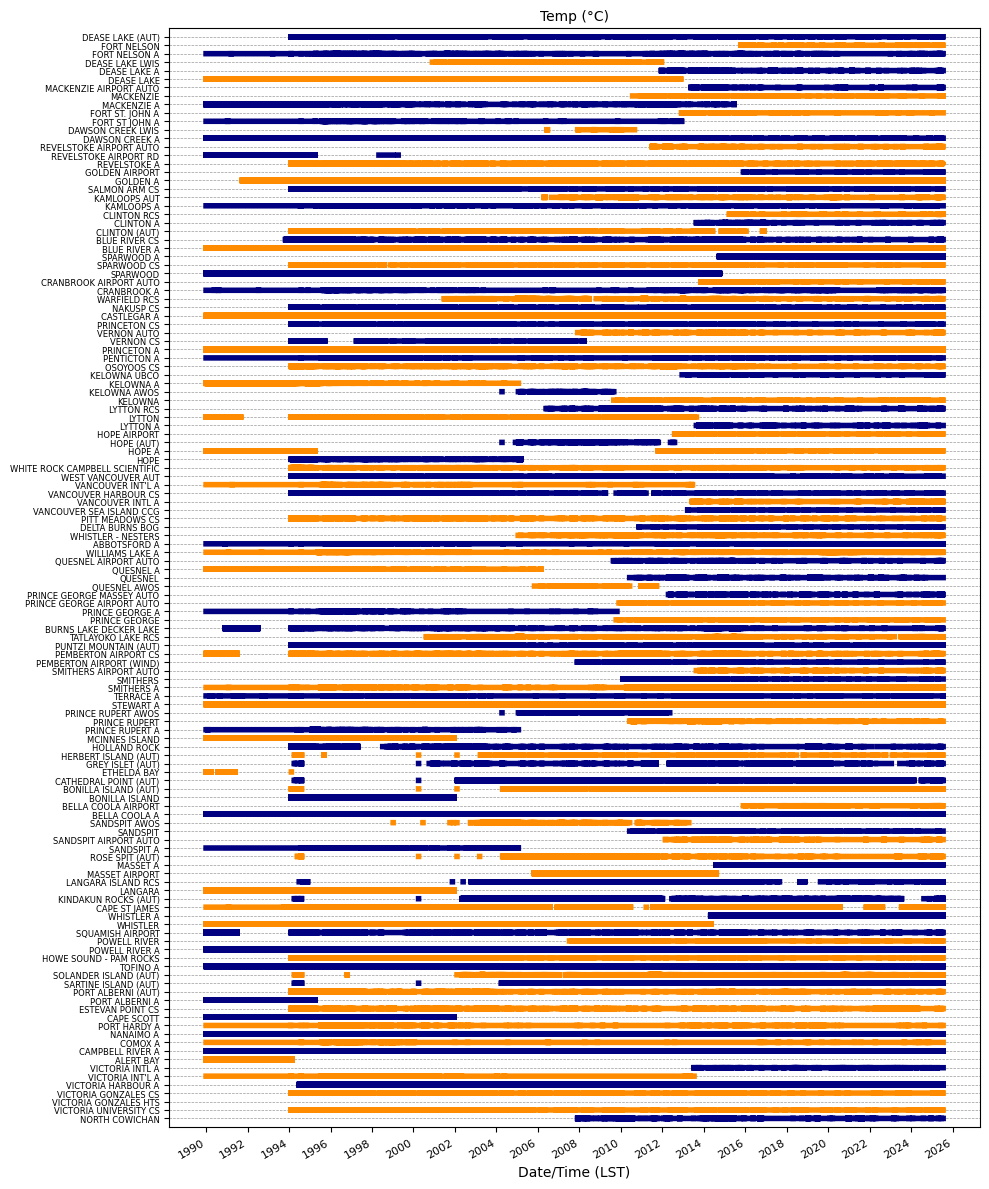

In [17]:
plt.figure(figsize=(10, 12))
plt.yticks(np.arange(len(stns)), stns, fontsize=6)
plt.ylim(-1, len(stns))
plt.xticks(
    ticks=pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS'),
    labels=[str(y.year) for y in pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS')],
    rotation=45,
    fontsize=8
)
color = ["navy", "darkorange"]

var = "Temp (°C)"
for i,stn in enumerate(stns):
    print(f"Plotting {var} for {stn} ({i+1}/{len(stns)})")
    data = get_stn(stn)[var]
    data = data.where(data.isna(), i)
    plt.axhline(y=i, color='black', linewidth=0.5, linestyle='--', alpha=0.4)
    data.plot(ax=plt.gca(), label=stn, drawstyle='steps-post', linewidth=4, color=color[i % 2])

plt.title(f"{var}", fontsize=10)
plt.tight_layout()
plt.show()

Plotting Rel Hum (%) for NORTH COWICHAN (1/129)
Plotting Rel Hum (%) for VICTORIA UNIVERSITY CS (2/129)


/users/rpayne/venv/wx-to-fwi/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


Plotting Rel Hum (%) for VICTORIA GONZALES HTS (3/129)
Plotting Rel Hum (%) for VICTORIA GONZALES CS (4/129)
Plotting Rel Hum (%) for VICTORIA HARBOUR A (5/129)
Plotting Rel Hum (%) for VICTORIA INT'L A (6/129)
Plotting Rel Hum (%) for VICTORIA INTL A (7/129)
Plotting Rel Hum (%) for ALERT BAY (8/129)
Plotting Rel Hum (%) for CAMPBELL RIVER A (9/129)
Plotting Rel Hum (%) for COMOX A (10/129)
Plotting Rel Hum (%) for NANAIMO A (11/129)
Plotting Rel Hum (%) for PORT HARDY A (12/129)
Plotting Rel Hum (%) for CAPE SCOTT (13/129)
Plotting Rel Hum (%) for ESTEVAN POINT CS (14/129)
Plotting Rel Hum (%) for PORT ALBERNI A (15/129)
Plotting Rel Hum (%) for PORT ALBERNI (AUT) (16/129)
Plotting Rel Hum (%) for SARTINE ISLAND (AUT) (17/129)
Plotting Rel Hum (%) for SOLANDER ISLAND (AUT) (18/129)
Plotting Rel Hum (%) for TOFINO A (19/129)
Plotting Rel Hum (%) for HOWE SOUND - PAM ROCKS (20/129)
Plotting Rel Hum (%) for POWELL RIVER A (21/129)
Plotting Rel Hum (%) for POWELL RIVER (22/129)
Plotting 

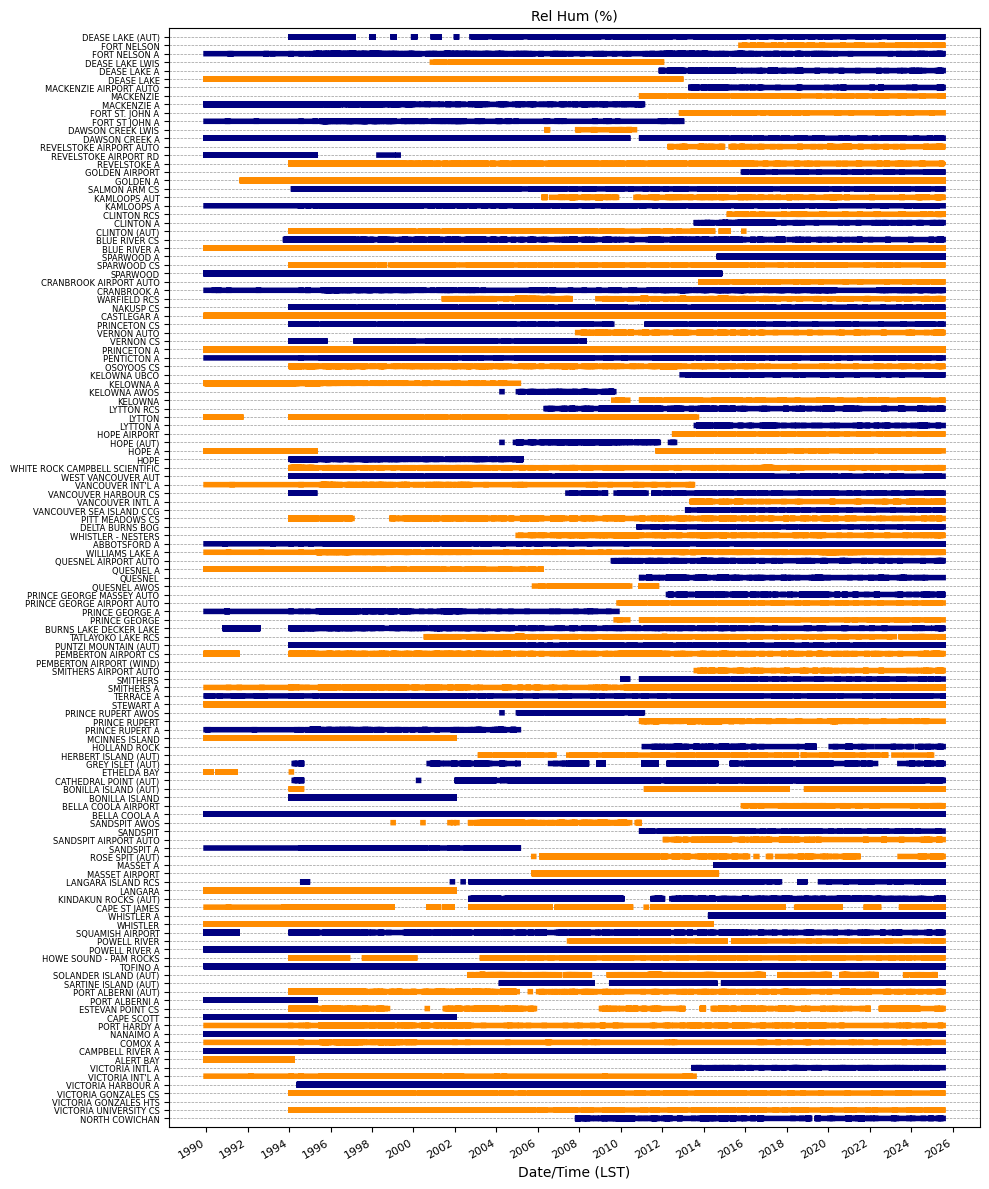

In [18]:
plt.figure(figsize=(10, 12))
plt.yticks(np.arange(len(stns)), stns, fontsize=6)
plt.ylim(-1, len(stns))
plt.xticks(
    ticks=pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS'),
    labels=[str(y.year) for y in pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS')],
    rotation=45,
    fontsize=8
)
color = ["navy", "darkorange"]

var = "Rel Hum (%)"
for i,stn in enumerate(stns):
    print(f"Plotting {var} for {stn} ({i+1}/{len(stns)})")
    data = get_stn(stn)[var]
    data = data.where(data.isna(), i)
    plt.axhline(y=i, color='black', linewidth=0.5, linestyle='--', alpha=0.4)
    data.plot(ax=plt.gca(), label=stn, drawstyle='steps-post', linewidth=4, color=color[i % 2])

plt.title(f"{var}", fontsize=10)
plt.tight_layout()
plt.show()

Plotting Wind Spd (km/h) for NORTH COWICHAN (1/129)
Plotting Wind Spd (km/h) for VICTORIA UNIVERSITY CS (2/129)


/users/rpayne/venv/wx-to-fwi/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


Plotting Wind Spd (km/h) for VICTORIA GONZALES HTS (3/129)
Plotting Wind Spd (km/h) for VICTORIA GONZALES CS (4/129)
Plotting Wind Spd (km/h) for VICTORIA HARBOUR A (5/129)
Plotting Wind Spd (km/h) for VICTORIA INT'L A (6/129)
Plotting Wind Spd (km/h) for VICTORIA INTL A (7/129)
Plotting Wind Spd (km/h) for ALERT BAY (8/129)
Plotting Wind Spd (km/h) for CAMPBELL RIVER A (9/129)
Plotting Wind Spd (km/h) for COMOX A (10/129)
Plotting Wind Spd (km/h) for NANAIMO A (11/129)
Plotting Wind Spd (km/h) for PORT HARDY A (12/129)
Plotting Wind Spd (km/h) for CAPE SCOTT (13/129)
Plotting Wind Spd (km/h) for ESTEVAN POINT CS (14/129)
Plotting Wind Spd (km/h) for PORT ALBERNI A (15/129)
Plotting Wind Spd (km/h) for PORT ALBERNI (AUT) (16/129)
Plotting Wind Spd (km/h) for SARTINE ISLAND (AUT) (17/129)
Plotting Wind Spd (km/h) for SOLANDER ISLAND (AUT) (18/129)
Plotting Wind Spd (km/h) for TOFINO A (19/129)
Plotting Wind Spd (km/h) for HOWE SOUND - PAM ROCKS (20/129)
Plotting Wind Spd (km/h) for POWE

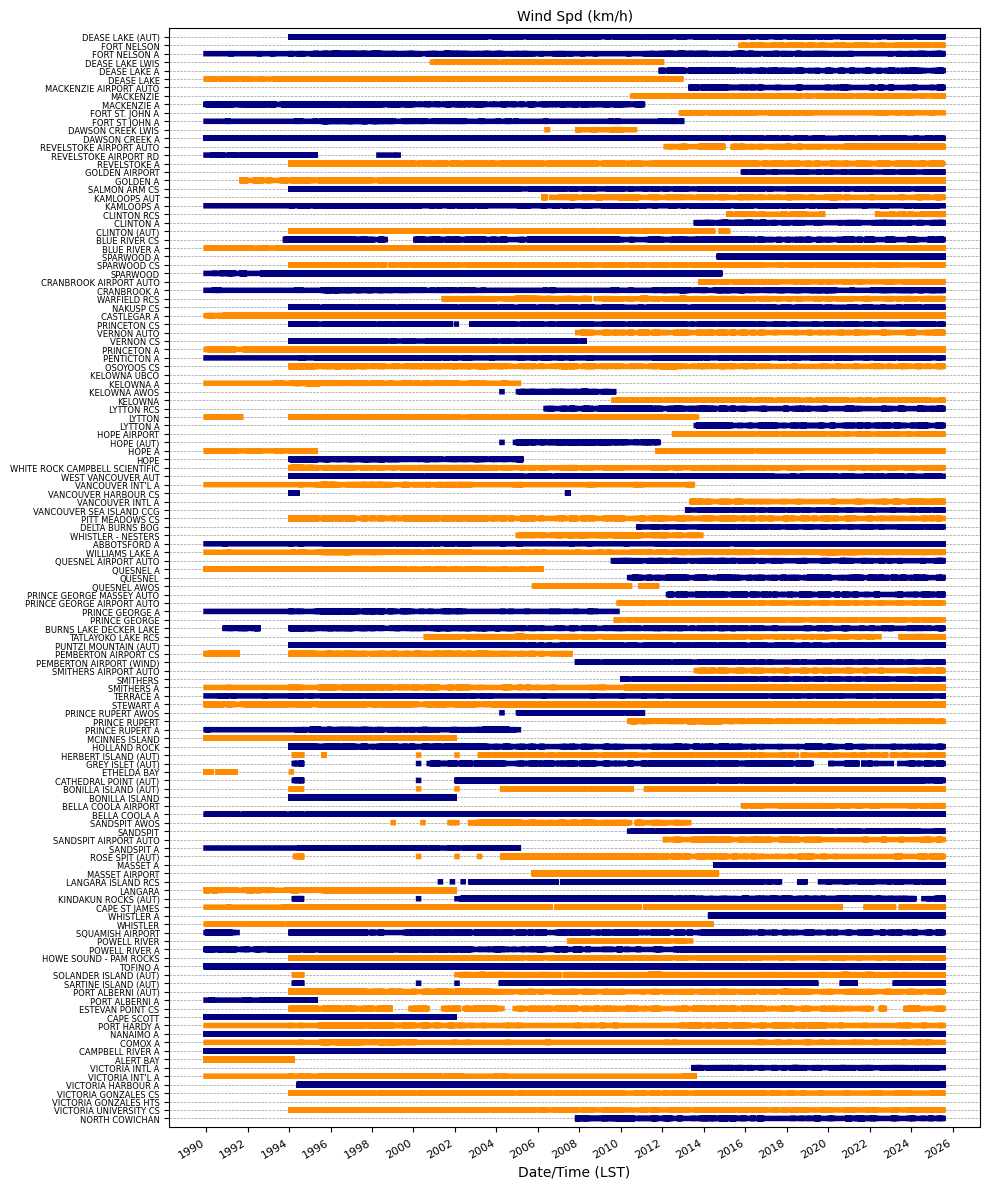

In [19]:
plt.figure(figsize=(10, 12))
plt.yticks(np.arange(len(stns)), stns, fontsize=6)
plt.ylim(-1, len(stns))
plt.xticks(
    ticks=pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS'),
    labels=[str(y.year) for y in pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS')],
    rotation=45,
    fontsize=8
)
color = ["navy", "darkorange"]

var = "Wind Spd (km/h)"
for i,stn in enumerate(stns):
    print(f"Plotting {var} for {stn} ({i+1}/{len(stns)})")
    data = get_stn(stn)[var]
    data = data.where(data.isna(), i)
    plt.axhline(y=i, color='black', linewidth=0.5, linestyle='--', alpha=0.4)
    data.plot(ax=plt.gca(), label=stn, drawstyle='steps-post', linewidth=4, color=color[i % 2])

plt.title(f"{var}", fontsize=10)
plt.tight_layout()
plt.show()

Plotting Precip. Amount (mm) for NORTH COWICHAN (1/129)
Plotting Precip. Amount (mm) for VICTORIA UNIVERSITY CS (2/129)


/users/rpayne/venv/wx-to-fwi/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


Plotting Precip. Amount (mm) for VICTORIA GONZALES HTS (3/129)
Plotting Precip. Amount (mm) for VICTORIA GONZALES CS (4/129)
Plotting Precip. Amount (mm) for VICTORIA HARBOUR A (5/129)
Plotting Precip. Amount (mm) for VICTORIA INT'L A (6/129)
Plotting Precip. Amount (mm) for VICTORIA INTL A (7/129)
Plotting Precip. Amount (mm) for ALERT BAY (8/129)
Plotting Precip. Amount (mm) for CAMPBELL RIVER A (9/129)
Plotting Precip. Amount (mm) for COMOX A (10/129)
Plotting Precip. Amount (mm) for NANAIMO A (11/129)
Plotting Precip. Amount (mm) for PORT HARDY A (12/129)
Plotting Precip. Amount (mm) for CAPE SCOTT (13/129)
Plotting Precip. Amount (mm) for ESTEVAN POINT CS (14/129)
Plotting Precip. Amount (mm) for PORT ALBERNI A (15/129)
Plotting Precip. Amount (mm) for PORT ALBERNI (AUT) (16/129)
Plotting Precip. Amount (mm) for SARTINE ISLAND (AUT) (17/129)
Plotting Precip. Amount (mm) for SOLANDER ISLAND (AUT) (18/129)
Plotting Precip. Amount (mm) for TOFINO A (19/129)
Plotting Precip. Amount (m

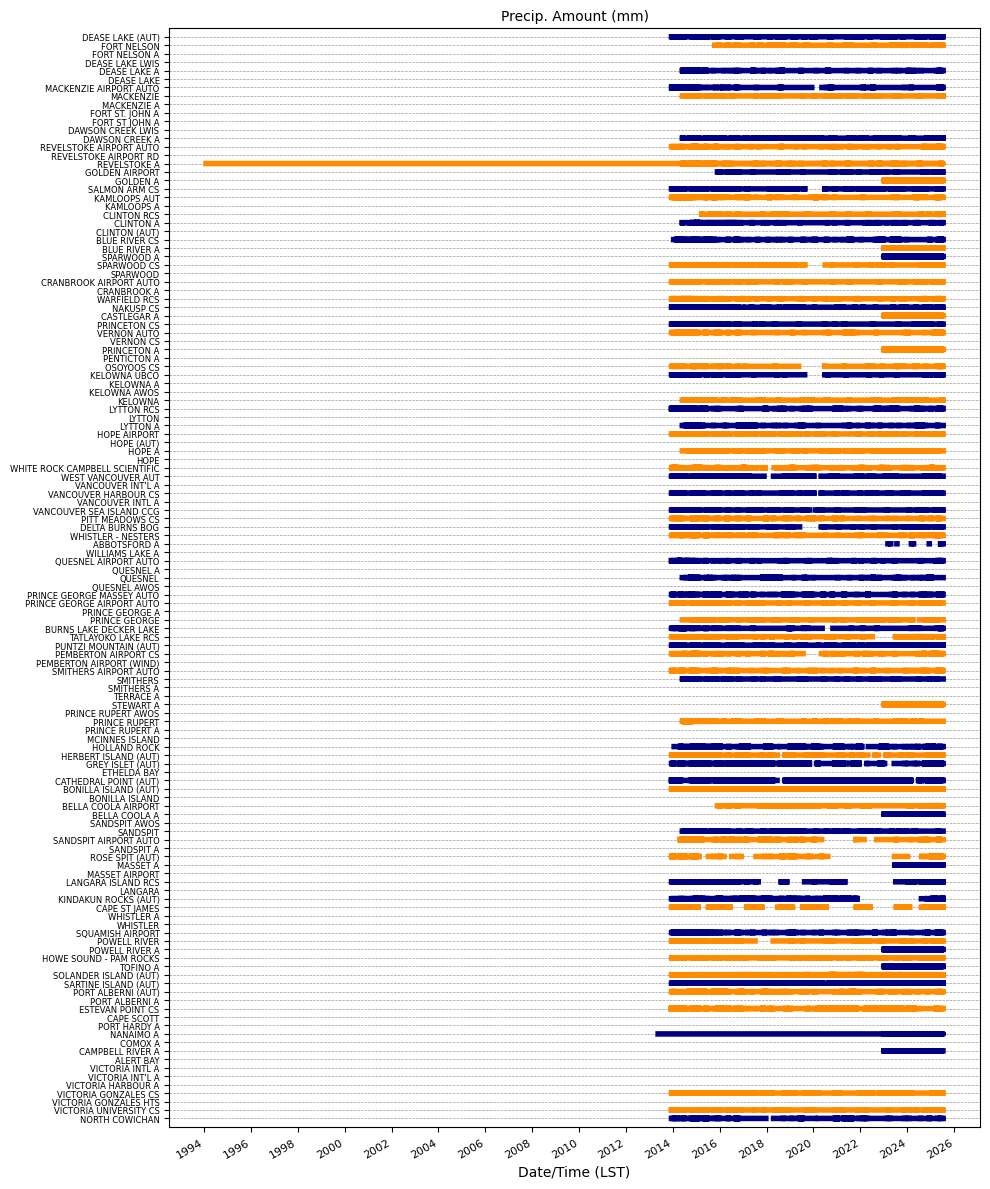

In [20]:
plt.figure(figsize=(10, 12))
plt.yticks(np.arange(len(stns)), stns, fontsize=6)
plt.ylim(-1, len(stns))
plt.xticks(
    ticks=pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS'),
    labels=[str(y.year) for y in pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS')],
    rotation=45,
    fontsize=8
)
color = ["navy", "darkorange"]

var = "Precip. Amount (mm)"
for i,stn in enumerate(stns):
    print(f"Plotting {var} for {stn} ({i+1}/{len(stns)})")
    data = get_stn(stn)[var]
    data = data.where(data.isna(), i)
    plt.axhline(y=i, color='black', linewidth=0.5, linestyle='--', alpha=0.4)
    data.plot(ax=plt.gca(), label=stn, drawstyle='steps-post', linewidth=4, color=color[i % 2])

plt.title(f"{var}", fontsize=10)
plt.tight_layout()
plt.show()

In [52]:
for i,stn in enumerate(stns_fromlist):
    if stn not in stns:
        print(f"Station {stn} (cid {ids_fromlist[i]}) not found in the list of relevant stations.")

Station TRIPLE ISLAND (cid 1068250) not found in the list of relevant stations.
Station MERRY ISLAND LIGHTSTATION (cid 1045100) not found in the list of relevant stations.
Station VICTORIA MARINE (cid 1018642) not found in the list of relevant stations.
Station EGG ISLAND (cid 1062646) not found in the list of relevant stations.
Station HOPE SLIDE (cid 1113581) not found in the list of relevant stations.
Station GREEN ISLAND (cid 1063298) not found in the list of relevant stations.
Station VERNON (cid 1128551) not found in the list of relevant stations.
Station FORT ST JAMES A (cid 1092972) not found in the list of relevant stations.
Station AMPHITRITE POINT (cid 1030426) not found in the list of relevant stations.
Station CHETWYND A (cid 1181508) not found in the list of relevant stations.
Station SCUDDER POINT (cid 1057133) not found in the list of relevant stations.
Station SHERINGHAM POINT (cid 1017254) not found in the list of relevant stations.
Station STEAMBOAT (cid 1197704) not

# CLEAN UP

In [15]:
# Constants
N_YEARS = LAST_YEAR - FIRST_YEAR + 1
N = 365*24*N_YEARS + 6*24  # 24 extra hours for 6 leap years
COVERAGE_THRESHOLD = 0.9

In [22]:
WS_coverage = {}
RH_coverage = {}

for i,stn in enumerate(stns):
    print(f"{i+1}/{len(stns)}")
    
    WS_data = get_stn(stn)["Wind Spd (km/h)"]
    WS_coverage = np.count_nonzero(~np.isnan(WS_data)) / N
    if WS_coverage >= COVERAGE_THRESHOLD:
        print(stn, WS_coverage)
        WS_coverage[stn] = WS_coverage

    RH_data = get_stn(stn)["Rel Hum (%)"]
    RH_coverage = np.count_nonzero(~np.isnan(RH_data)) / N
    if RH_coverage >= COVERAGE_THRESHOLD:
        RH_coverage[stn] = RH_coverage

1/126
2/126
VICTORIA UNIVERSITY CS 0.9967920636659


TypeError: 'float' object does not support item assignment

Plotting Rel Hum (%) for VICTORIA UNIVERSITY CS (1/30)
Plotting Rel Hum (%) for VICTORIA GONZALES CS (2/30)


/users/rpayne/venv/wx-to-fwi/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


Plotting Rel Hum (%) for VICTORIA HARBOUR A (3/30)
Plotting Rel Hum (%) for CAMPBELL RIVER A (4/30)
Plotting Rel Hum (%) for COMOX A (5/30)
Plotting Rel Hum (%) for NANAIMO A (6/30)
Plotting Rel Hum (%) for PORT HARDY A (7/30)
Plotting Rel Hum (%) for PORT ALBERNI (AUT) (8/30)
Plotting Rel Hum (%) for POWELL RIVER A (9/30)
Plotting Rel Hum (%) for SQUAMISH AIRPORT (10/30)
Plotting Rel Hum (%) for TERRACE A (11/30)
Plotting Rel Hum (%) for PEMBERTON AIRPORT CS (12/30)
Plotting Rel Hum (%) for PUNTZI MOUNTAIN (AUT) (13/30)
Plotting Rel Hum (%) for BURNS LAKE DECKER LAKE (14/30)
Plotting Rel Hum (%) for WILLIAMS LAKE A (15/30)
Plotting Rel Hum (%) for ABBOTSFORD A (16/30)
Plotting Rel Hum (%) for PITT MEADOWS CS (17/30)
Plotting Rel Hum (%) for WEST VANCOUVER AUT (18/30)
Plotting Rel Hum (%) for WHITE ROCK CAMPBELL SCIENTIFIC (19/30)
Plotting Rel Hum (%) for OSOYOOS CS (20/30)
Plotting Rel Hum (%) for PENTICTON A (21/30)
Plotting Rel Hum (%) for CASTLEGAR A (22/30)
Plotting Rel Hum (%) fo

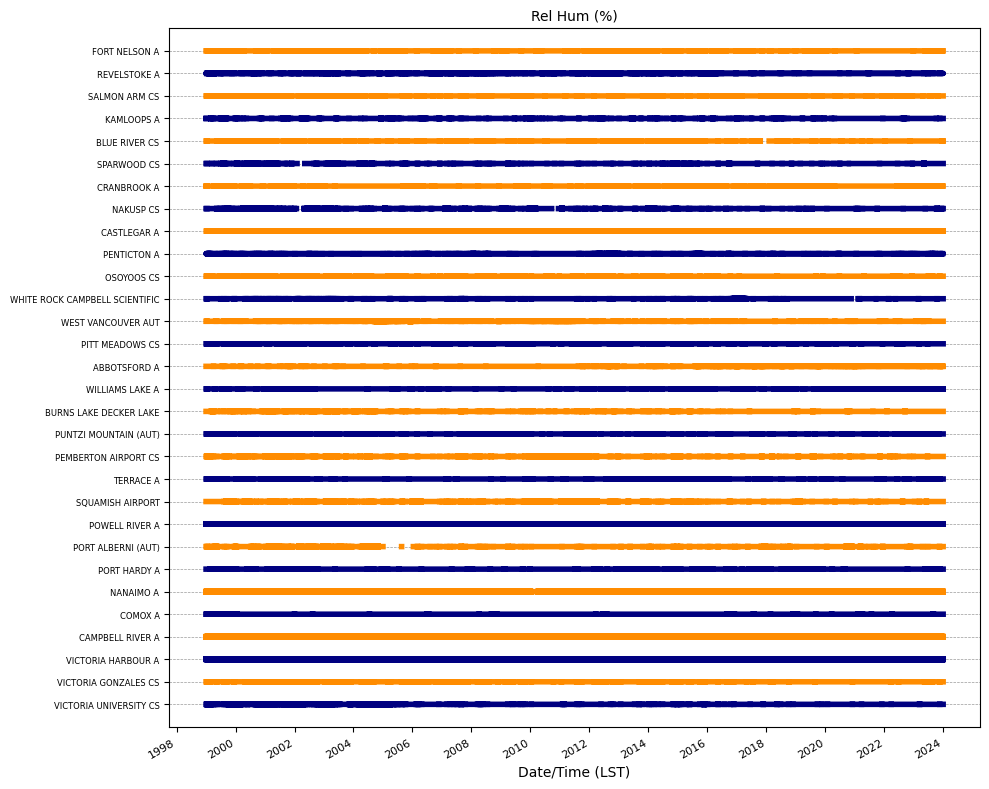

In [19]:
plt.figure(figsize=(10, 8))
plt.yticks(np.arange(len(RH_coverage.keys())), RH_coverage.keys(), fontsize=6)
plt.ylim(-1, len(RH_coverage.keys()))
plt.xticks(
    ticks=pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS'),
    labels=[str(y.year) for y in pd.date_range(start='1990-01-01', end='2026-01-01', freq='2YS')],
    rotation=45,
    fontsize=8
)
color = ["navy", "darkorange"]

var = "Rel Hum (%)"
for i,stn in enumerate(RH_coverage.keys()):
    print(f"Plotting {var} for {stn} ({i+1}/{len(RH_coverage.keys())})")
    data = get_stn(stn)[var]
    data = data.where(data.isna(), i)
    plt.axhline(y=i, color='black', linewidth=0.5, linestyle='--', alpha=0.4)
    data.plot(ax=plt.gca(), label=stn, drawstyle='steps-post', linewidth=4, color=color[i % 2])

plt.title(f"{var}", fontsize=10)
plt.tight_layout()
plt.show()